In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.datasets import make_moons

In [2]:
def kernel(X1, X2, scale=1.0, sigma_f=1.0):
    ''' Uncomment for Gaussian Kernel '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp((-0.5 / scale**2) * sqdist)
#     ''' Uncomment for Linear Kernel '''
#     return X1 @ X2.T
def dataSet2():
    X, y = make_moons(n_samples=100, noise=0.1)
    y = np.where(y==0, -1, y)
    y = y.reshape(-1,1)
    S = (y>0).squeeze()
    x_pos = X[S]
    x_neg = X[np.invert(S)]
    return X,y,x_pos,x_neg

In [3]:
def dualOptimizer(H,m,y, C):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0
    y = y*1.0 
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(-np.eye(m))

    #Changing the constraints for soft margin. For hard margin, C = 0.    
    h = cvxopt_matrix(np.ones(m) * C)
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10

    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

def pred(y,a,X,p,b):
    k = kernel(X,p)
    return (y * a).T @ k +b
    
def predb(y,a,X,p):    
    k = kernel(X,p)
    xc = (y * a).T @ k
    print(k.shape,xc.shape)
    return np.average(y.T-xc)

(7, 7) (1, 7)


<a list of 3 text.Text objects>

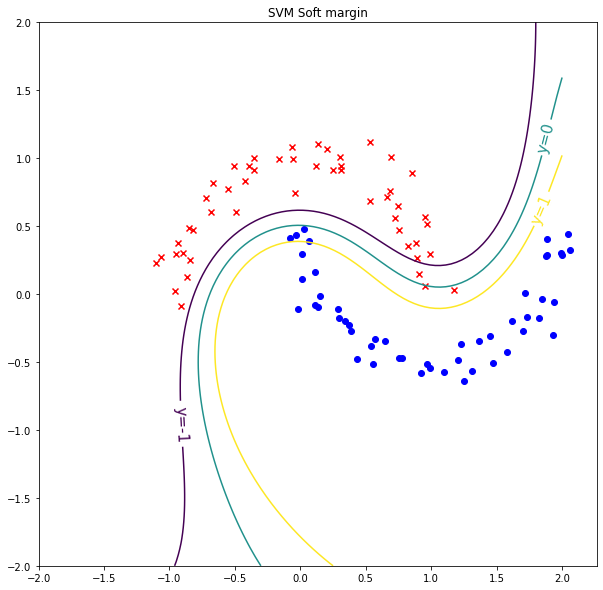

In [14]:
''' Implementing SVM soft margin '''
'''Converting second term of dual objective function into standard form, a.T*H*a for the optimizer'''
np.random.seed(0)
X,y,x_pos,x_neg = dataSet2()
k = kernel(X,X)
t = np.dot(y,y.T)
H = k*t              
m,n = X.shape
C = float(input("Enter constraint constant(C): "))

alphas = dualOptimizer(H,m,y,C)

#Selecting the set of indices S corresponding to non zero parameters
S = (alphas > 1e-4).flatten()

w = ((y[S] * alphas[S]).T @ X[S]).reshape(-1,1)

#Computing b
b = predb(y[S],alphas[S],X[S],X[S])

#Display results
# print('Alphas: ',alphas,'\n Support Vectors: ',S.reshape(-1,1))
# print('Alphas for Support Vectors = ',alphas[alphas > 1e-4])
# print('w = ', w.flatten())
# print('b = ', b)

fig = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x0, x1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p = np.array([x0, x1]).reshape(2, -1).T
pr = pred(y[S],alphas[S],X[S],p,b)
#print(pr)


'''margin hyperplanes'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp = plt.contour(x0, x1, pred(y[S],alphas[S],X[S],p,b).reshape(100, 100), np.array([-1, 0, 1]))
plt.title("SVM Soft margin")
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=15)